## &#x1F310; &nbsp; Code Library, Style, and Links
The previous notebooks:

&#x1F310; &nbsp; [PASSNYC. Data Exploration](https://www.kaggle.com/olgabelitskaya/passnyc-data-exploration)

&#x1F310; &nbsp; [PASSNYC. Numeric and Categorical Variables](https://www.kaggle.com/olgabelitskaya/passnyc-numeric-and-categorical-variables)

&#x1F310; &nbsp; [PASSNYC. Comparing All Districts with 5th District](passnyc-comparing-all-districts-with-5th-district)

&#x1F310; &nbsp; [PASSNYC. Regression Methods](https://www.kaggle.com/olgabelitskaya/passnyc-regression-methods)

&#x1F310; &nbsp; [PASSNYC. Neural Networks](https://www.kaggle.com/olgabelitskaya/passnyc-neural-networks)

Useful Links:

&#x1F310; &nbsp; [School Quality Reports. Educator Guide](http://schools.nyc.gov/NR/rdonlyres/967E0EE1-7E5D-4E47-BC21-573FEEE23AE2/0/201516EducatorGuideHS9252017.pdf)

In [1]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #37c9e1; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;}
h4 {color: #37c9e1; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #aaa;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;}               
</style>

In [2]:
import numpy as np 
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from descartes import PolygonPatch

from IPython.display import HTML
from sklearn.preprocessing import minmax_scale

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.preprocessing import OneHotEncoder

from keras.models import Sequential, load_model, Model
from keras.optimizers import SGD, RMSprop
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation, Flatten, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers.embeddings import Embedding

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.callbacks import ModelCheckpoint

from keras.applications.inception_v3 import InceptionV3 
from keras.applications.inception_v3 import preprocess_input as v3_preprocess_input

from keras.applications.nasnet import NASNetLarge 
from keras.applications.nasnet import preprocess_input as nas_preprocess_input

Using TensorFlow backend.


In [3]:
def scores(regressor, y_train, y_valid, y_test, y_train_reg, y_valid_reg, y_test_reg):
    print("_______________________________________")
    print(regressor)
    print("_______________________________________")
    print("EV score. Train: ", explained_variance_score(y_train, y_train_reg))
    print("EV score. Valid: ", explained_variance_score(y_valid, y_valid_reg))
    print("EV score. Test: ", explained_variance_score(y_test, y_test_reg))
    print("---------")
    print("R2 score. Train: ", r2_score(y_train, y_train_reg))
    print("R2 score. Valid: ", r2_score(y_valid, y_valid_reg))
    print("R2 score. Test: ", r2_score(y_test, y_test_reg))
    print("---------")
    print("MSE score. Train: ", mean_squared_error(y_train, y_train_reg))
    print("MSE score. Valid: ", mean_squared_error(y_valid, y_valid_reg))
    print("MSE score. Test: ", mean_squared_error(y_test, y_test_reg))
    print("---------")
    print("MAE score. Train: ", mean_absolute_error(y_train, y_train_reg))
    print("MAE score. Valid: ", mean_absolute_error(y_valid, y_valid_reg))
    print("MAE score. Test: ", mean_absolute_error(y_test, y_test_reg))
    print("---------")
    print("MdAE score. Train: ", median_absolute_error(y_train, y_train_reg))
    print("MdAE score. Valid: ", median_absolute_error(y_valid, y_valid_reg))
    print("MdAE score. Test: ", median_absolute_error(y_test, y_test_reg))
    
def loss_plot(fit_history, n):
    plt.figure(figsize=(14, 6))

    plt.plot(fit_history.history['loss'][n:], 
             color='slategray', label = 'train')
    plt.plot(fit_history.history['val_loss'][n:], 
             color='#37c9e1', label = 'valid')

    plt.legend()
    plt.title('Loss Function');  
    
def mae_plot(fit_history, n):
    plt.figure(figsize=(14, 6))

    plt.plot(fit_history.history['mean_absolute_error'][n:], 
             color='slategray', label = 'train')
    plt.plot(fit_history.history['val_mean_absolute_error'][n:], 
             color='#37c9e1', label = 'valid')

    plt.legend()
    plt.title('Mean Absolute Error');

In [4]:
style_dict = {'background-color':'slategray',
              'color':'#37c9e1',
              'border-color': 'white'}

## &#x1F310; &nbsp; Load and Preprocess the Data

In [5]:
school_explorer = pd.read_csv('2016 School Explorer.csv')
d5_shsat = pd.read_csv('D5 SHSAT Registrations and Testers.csv')
school_explorer.shape, d5_shsat.shape

((1272, 161), (140, 7))

In [6]:
# Fillna or replace values
numeric_list = list(school_explorer\
.columns[[7,8]+list(range(16,27))+[28,30,32,34,36]+list(range(41,161))])
target_list = ['Average ELA Proficiency','Average Math Proficiency']

school_explorer = school_explorer.drop(['Adjusted Grade',
                                        'New?',
                                        'Other Location Code in LCGMS'], 
                                       axis=1)
school_explorer.loc[[427,1023,712,908],'School Name'] = \
['P.S. 212 D12','P.S. 212 D30','P.S. 253 D21','P.S. 253 D27']

percent_list = ['Percent ELL','Percent Asian','Percent Black',
                'Percent Hispanic','Percent Black / Hispanic',
                'Percent White','Student Attendance Rate',
                'Percent of Students Chronically Absent',
                'Rigorous Instruction %','Collaborative Teachers %',
                'Supportive Environment %','Effective School Leadership %',
                'Strong Family-Community Ties %','Trust %']

for el in percent_list:
    school_explorer[el] = school_explorer[el].astype('str')
    school_explorer[el] = school_explorer[el].str.replace("%", "")
    school_explorer[el] = school_explorer[el].str.replace("nan", "0")
    school_explorer[el] = school_explorer[el].astype(float)
    school_explorer[el].replace(0, np.NaN, inplace=True)
    school_explorer[el] = school_explorer[el].interpolate()
    
school_explorer['Economic Need Index'] = \
school_explorer['Economic Need Index'].interpolate()
school_explorer['Average ELA Proficiency'] = \
school_explorer['Average ELA Proficiency'].interpolate()
school_explorer['Average Math Proficiency'] = \
school_explorer['Average Math Proficiency'].interpolate()

school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].astype('str') 
for s in [",","$"," "]:
    school_explorer['School Income Estimate'] = \
    school_explorer['School Income Estimate'].str.replace(s, "")
school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].str.replace("nan", "0")

school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].astype(float)
school_explorer['School Income Estimate'].replace(0, np.NaN, inplace=True)
school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].interpolate()

rating_list = ['Rigorous Instruction Rating','Collaborative Teachers Rating',
               'Supportive Environment Rating','Effective School Leadership Rating',
               'Strong Family-Community Ties Rating','Strong Family-Community Ties Rating',
               'Trust Rating','Student Achievement Rating']

for el in rating_list:
    moda_value = school_explorer[el].value_counts().idxmax()
    school_explorer[el] = school_explorer[el].fillna(moda_value) 
    
category_list1 = ['District','Community School?','City','Grades']
                  
category_list2 = ['Rigorous Instruction Rating',
                  'Collaborative Teachers Rating',
                  'Supportive Environment Rating',
                  'Effective School Leadership Rating',
                  'Strong Family-Community Ties Rating',
                  'Trust Rating','Student Achievement Rating']

for feature in category_list1:
    feature_cat = pd.factorize(school_explorer[feature])
    school_explorer[feature] = feature_cat[0]
    
for feature in category_list2:
    feature_pairs = dict(zip(['Not Meeting Target', 'Meeting Target', 
                              'Approaching Target', 'Exceeding Target'],
                             ['0','2','1','3']))
    school_explorer[feature].replace(feature_pairs,inplace=True)
    school_explorer[feature] = school_explorer[feature].astype(int)
    
category_list = list(category_list1+category_list2)
    
print('NaN count = ', sum(school_explorer.isna().sum()))  

NaN count =  0


## &#x1F310; &nbsp; Split the Data for Neural Networks' Training

In [7]:
features1 = school_explorer[numeric_list].values
features2 = school_explorer[numeric_list+category_list]
targets1 = school_explorer['Average Math Proficiency'].values
targets2 = school_explorer['Average ELA Proficiency'].values

features_enc = features2
encode = OneHotEncoder(sparse=False)

for column in category_list:
    encode.fit(features2[[column]])
    transform = encode.transform(features2[[column]])
    
    transform = \
    pd.DataFrame(transform, 
                 columns=[(column+"_"+str(i)) for i in features2[column].value_counts().index])
    transform = transform.set_index(features2.index.values)
    
    features_enc = pd.concat([features_enc, transform], axis=1)
    features_enc = features_enc.drop(column, 1)
    
features2 = features2.values
features_enc = features_enc.values

In [8]:
# data = school_explorer, features = numeric variables, targets = Average Math Proficiency

X_train1, X_test1, y_train1, y_test1 = \
train_test_split(features1, targets1, test_size=0.3, random_state=1)

n = int(len(X_test1)/2)
X_valid1, y_valid1 = X_test1[:n], y_test1[:n]
X_test1, y_test1 = X_test1[n:], y_test1[n:]
X_train1.shape, X_test1.shape, X_valid1.shape, y_train1.shape, y_test1.shape, y_valid1.shape

((890, 138), (191, 138), (191, 138), (890,), (191,), (191,))

In [9]:
# data = school_explorer, features = numeric variables, targets = Average ELA Proficiency

X_train2, X_test2, y_train2, y_test2 = \
train_test_split(features1, targets2, test_size=0.3, random_state=1)

n = int(len(X_test2)/2)
X_valid2, y_valid2 = X_test2[:n], y_test2[:n]
X_test2, y_test2 = X_test2[n:], y_test2[n:]
X_train2.shape, X_test2.shape, X_valid2.shape, y_train2.shape, y_test2.shape, y_valid2.shape

((890, 138), (191, 138), (191, 138), (890,), (191,), (191,))

In [10]:
# data = school_explorer, features = numeric & encoded categorical variables, targets = Average Math Proficiency

X_train3, X_test3, y_train3, y_test3 = \
train_test_split(features_enc, targets1, test_size=0.3, random_state=1)

n = int(len(X_test3)/2)
X_valid3, y_valid3 = X_test3[:n], y_test3[:n]
X_test3, y_test3 = X_test3[n:], y_test3[n:]
X_train3.shape, X_test3.shape, X_valid3.shape, y_train3.shape, y_test3.shape, y_valid3.shape

((890, 286), (191, 286), (191, 286), (890,), (191,), (191,))

In [11]:
# data = school_explorer, features = numeric & encoded categorical variables, targets = Average ELA Proficiency

X_train4, X_test4, y_train4, y_test4 = \
train_test_split(features_enc, targets2, test_size=0.3, random_state=1)

n = int(len(X_test4)/2)
X_valid4, y_valid4 = X_test4[:n], y_test4[:n]
X_test4, y_test4 = X_test4[n:], y_test4[n:]
X_train4.shape, X_test4.shape, X_valid4.shape, y_train4.shape, y_test4.shape, y_valid4.shape

((890, 286), (191, 286), (191, 286), (890,), (191,), (191,))

## &#x1F310; &nbsp; Neural Network Models
### MLP
#### Numeric features

In [12]:
def mlp_model1():
    model = Sequential()
    
    model.add(Dense(138, input_dim=138))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dense(138*4))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(Dense(138*16))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dense(138*16))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model

mlp_model1 = mlp_model1()

In [13]:
mlp_checkpointer1 = ModelCheckpoint(filepath='mlp_model1.passnyc.hdf5', 
                                    verbose=2, save_best_only=True)
mlp_lr_reduction1 = ReduceLROnPlateau(monitor='val_loss', 
                                      patience=5, verbose=2, factor=0.2)

In [14]:
mlp_history1 = mlp_model1.fit(X_train1, y_train1, 
                              epochs=100, batch_size=16, verbose=2,
                              validation_data=(X_valid1, y_valid1),
                              callbacks=[mlp_checkpointer1,mlp_lr_reduction1])

Train on 890 samples, validate on 191 samples
Epoch 1/100
 - 13s - loss: 457260661.0887 - mean_absolute_error: 3946.3849 - val_loss: 3.3176 - val_mean_absolute_error: 1.6888

Epoch 00001: val_loss improved from inf to 3.31757, saving model to mlp_model1.passnyc.hdf5
Epoch 2/100
 - 5s - loss: 7804.2478 - mean_absolute_error: 36.9160 - val_loss: 7.1010 - val_mean_absolute_error: 2.0469

Epoch 00002: val_loss did not improve from 3.31757
Epoch 3/100
 - 5s - loss: 1654376.6482 - mean_absolute_error: 189.9621 - val_loss: 34878830.5131 - val_mean_absolute_error: 5343.6354

Epoch 00003: val_loss did not improve from 3.31757
Epoch 4/100
 - 5s - loss: 764648.4145 - mean_absolute_error: 164.3060 - val_loss: 5475.1860 - val_mean_absolute_error: 67.1486

Epoch 00004: val_loss did not improve from 3.31757
Epoch 5/100
 - 5s - loss: 6137.5501 - mean_absolute_error: 43.0389 - val_loss: 1.1091 - val_mean_absolute_error: 0.9476

Epoch 00005: val_loss improved from 3.31757 to 1.10908, saving model to mlp

 - 5s - loss: 0.1616 - mean_absolute_error: 0.3070 - val_loss: 0.1079 - val_mean_absolute_error: 0.2571

Epoch 00044: val_loss improved from 0.11784 to 0.10787, saving model to mlp_model1.passnyc.hdf5
Epoch 45/100
 - 5s - loss: 0.1591 - mean_absolute_error: 0.3061 - val_loss: 0.2226 - val_mean_absolute_error: 0.3627

Epoch 00045: val_loss did not improve from 0.10787
Epoch 46/100
 - 5s - loss: 0.1528 - mean_absolute_error: 0.3016 - val_loss: 0.1161 - val_mean_absolute_error: 0.2532

Epoch 00046: val_loss did not improve from 0.10787
Epoch 47/100
 - 5s - loss: 0.1631 - mean_absolute_error: 0.3041 - val_loss: 0.1202 - val_mean_absolute_error: 0.2573

Epoch 00047: val_loss did not improve from 0.10787
Epoch 48/100
 - 5s - loss: 0.1538 - mean_absolute_error: 0.3055 - val_loss: 0.3106 - val_mean_absolute_error: 0.4604

Epoch 00048: val_loss did not improve from 0.10787
Epoch 49/100
 - 5s - loss: 0.1386 - mean_absolute_error: 0.2850 - val_loss: 0.3176 - val_mean_absolute_error: 0.4755

Epoch

 - 5s - loss: 0.0642 - mean_absolute_error: 0.1941 - val_loss: 0.0744 - val_mean_absolute_error: 0.2150

Epoch 00088: val_loss did not improve from 0.06610
Epoch 89/100
 - 5s - loss: 0.0647 - mean_absolute_error: 0.1956 - val_loss: 0.0676 - val_mean_absolute_error: 0.1941

Epoch 00089: val_loss did not improve from 0.06610
Epoch 90/100
 - 5s - loss: 0.0646 - mean_absolute_error: 0.1944 - val_loss: 0.0668 - val_mean_absolute_error: 0.2008

Epoch 00090: val_loss did not improve from 0.06610
Epoch 91/100
 - 5s - loss: 0.0645 - mean_absolute_error: 0.1948 - val_loss: 0.0688 - val_mean_absolute_error: 0.2051

Epoch 00091: val_loss did not improve from 0.06610

Epoch 00091: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.
Epoch 92/100
 - 5s - loss: 0.0632 - mean_absolute_error: 0.1926 - val_loss: 0.0656 - val_mean_absolute_error: 0.1973

Epoch 00092: val_loss improved from 0.06610 to 0.06562, saving model to mlp_model1.passnyc.hdf5
Epoch 93/100
 - 5s - loss: 0.0629 - mean_a

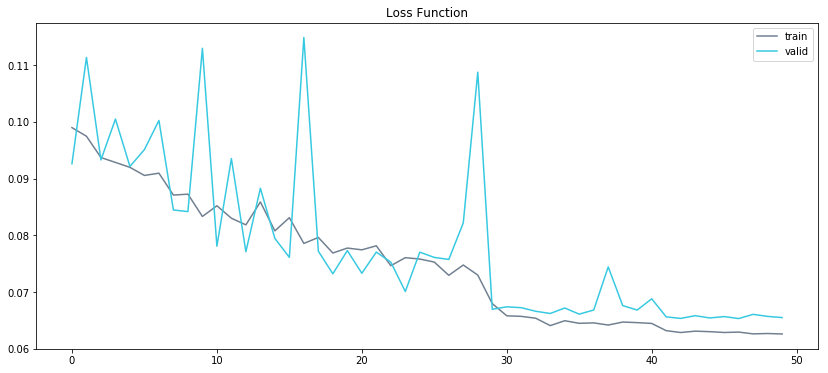

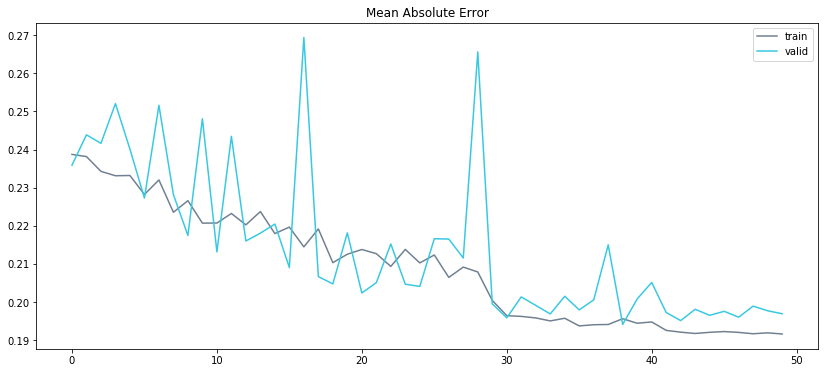

In [17]:
loss_plot(mlp_history1,50)
mae_plot(mlp_history1,50)

In [18]:
mlp_model1.load_weights('mlp_model1.passnyc.hdf5')
y_train_mlp1 = mlp_model1.predict(X_train1)
y_valid_mlp1 = mlp_model1.predict(X_valid1)
y_test_mlp1 = mlp_model1.predict(X_test1)

scores('MLP; \nNumeric Features; \nAverage Math Proficiency', 
       y_train1, y_valid1, y_test1, y_train_mlp1, y_valid_mlp1, y_test_mlp1)

_______________________________________
MLP; Average Math Proficiency
_______________________________________
EV score. Train:  0.7164918373586894
EV score. Valid:  0.6904124032993697
EV score. Test:  0.7354538569613821
---------
R2 score. Train:  0.7155908914556508
R2 score. Valid:  0.6903599492223027
R2 score. Test:  0.735447585338685
---------
MSE score. Train:  0.06265970533179265
MSE score. Valid:  0.06531837952998984
MSE score. Test:  0.05499829975417488
---------
MAE score. Train:  0.19121946533431722
MAE score. Valid:  0.19602120180612667
MAE score. Test:  0.18647031604307482
---------
MdAE score. Train:  0.15346560955047606
MdAE score. Valid:  0.16106279373168952
MdAE score. Test:  0.14875087738037118


In [19]:
def mlp_model2():
    model = Sequential()
    
    model.add(Dense(138, input_dim=138))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dense(138*4))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(Dense(138*16))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dense(138*16))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model

mlp_model2 = mlp_model2()

In [20]:
mlp_checkpointer2 = ModelCheckpoint(filepath='mlp_model2.passnyc.hdf5', 
                                    verbose=2, save_best_only=True)
mlp_lr_reduction2 = ReduceLROnPlateau(monitor='val_loss', 
                                      patience=5, verbose=2, factor=0.2)

In [21]:
mlp_history2 = mlp_model2.fit(X_train2, y_train2, 
                              epochs=100, batch_size=16, verbose=2,
                              validation_data=(X_valid2, y_valid2),
                              callbacks=[mlp_checkpointer2,mlp_lr_reduction2])

Train on 890 samples, validate on 191 samples
Epoch 1/100
 - 6s - loss: 446121632.4042 - mean_absolute_error: 3911.7552 - val_loss: 1.5315 - val_mean_absolute_error: 1.0933

Epoch 00001: val_loss improved from inf to 1.53145, saving model to mlp_model2.passnyc.hdf5
Epoch 2/100
 - 5s - loss: 6892.2303 - mean_absolute_error: 39.3112 - val_loss: 10.9538 - val_mean_absolute_error: 3.1969

Epoch 00002: val_loss did not improve from 1.53145
Epoch 3/100
 - 5s - loss: 4750986.6312 - mean_absolute_error: 491.4436 - val_loss: 1.5657 - val_mean_absolute_error: 1.0383

Epoch 00003: val_loss did not improve from 1.53145
Epoch 4/100
 - 5s - loss: 7610.4827 - mean_absolute_error: 35.7258 - val_loss: 0.8644 - val_mean_absolute_error: 0.6713

Epoch 00004: val_loss improved from 1.53145 to 0.86442, saving model to mlp_model2.passnyc.hdf5
Epoch 5/100
 - 5s - loss: 3443.3432 - mean_absolute_error: 22.5754 - val_loss: 77.6738 - val_mean_absolute_error: 8.2846

Epoch 00005: val_loss did not improve from 0.8


Epoch 00044: val_loss improved from 0.21284 to 0.10667, saving model to mlp_model2.passnyc.hdf5
Epoch 45/100
 - 5s - loss: 0.0977 - mean_absolute_error: 0.2341 - val_loss: 0.0949 - val_mean_absolute_error: 0.2215

Epoch 00045: val_loss improved from 0.10667 to 0.09486, saving model to mlp_model2.passnyc.hdf5
Epoch 46/100
 - 6s - loss: 0.0998 - mean_absolute_error: 0.2382 - val_loss: 0.1757 - val_mean_absolute_error: 0.3394

Epoch 00046: val_loss did not improve from 0.09486
Epoch 47/100
 - 5s - loss: 0.0982 - mean_absolute_error: 0.2354 - val_loss: 0.1568 - val_mean_absolute_error: 0.3042

Epoch 00047: val_loss did not improve from 0.09486
Epoch 48/100
 - 5s - loss: 0.0874 - mean_absolute_error: 0.2237 - val_loss: 0.0888 - val_mean_absolute_error: 0.2250

Epoch 00048: val_loss improved from 0.09486 to 0.08876, saving model to mlp_model2.passnyc.hdf5
Epoch 49/100
 - 5s - loss: 0.0872 - mean_absolute_error: 0.2256 - val_loss: 0.1587 - val_mean_absolute_error: 0.3239

Epoch 00049: val_lo


Epoch 00087: val_loss improved from 0.03483 to 0.03476, saving model to mlp_model2.passnyc.hdf5
Epoch 88/100
 - 5s - loss: 0.0330 - mean_absolute_error: 0.1343 - val_loss: 0.0344 - val_mean_absolute_error: 0.1344

Epoch 00088: val_loss improved from 0.03476 to 0.03437, saving model to mlp_model2.passnyc.hdf5
Epoch 89/100
 - 5s - loss: 0.0325 - mean_absolute_error: 0.1322 - val_loss: 0.0343 - val_mean_absolute_error: 0.1347

Epoch 00089: val_loss improved from 0.03437 to 0.03428, saving model to mlp_model2.passnyc.hdf5
Epoch 90/100
 - 5s - loss: 0.0326 - mean_absolute_error: 0.1328 - val_loss: 0.0342 - val_mean_absolute_error: 0.1343

Epoch 00090: val_loss improved from 0.03428 to 0.03421, saving model to mlp_model2.passnyc.hdf5
Epoch 91/100
 - 5s - loss: 0.0326 - mean_absolute_error: 0.1333 - val_loss: 0.0341 - val_mean_absolute_error: 0.1345

Epoch 00091: val_loss improved from 0.03421 to 0.03414, saving model to mlp_model2.passnyc.hdf5
Epoch 92/100
 - 5s - loss: 0.0326 - mean_absolu

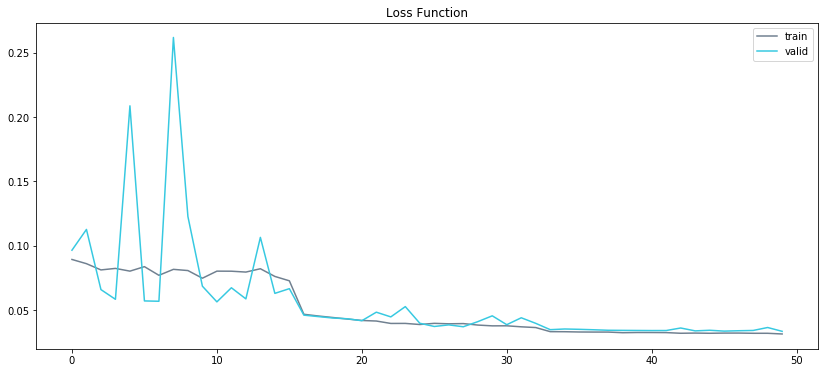

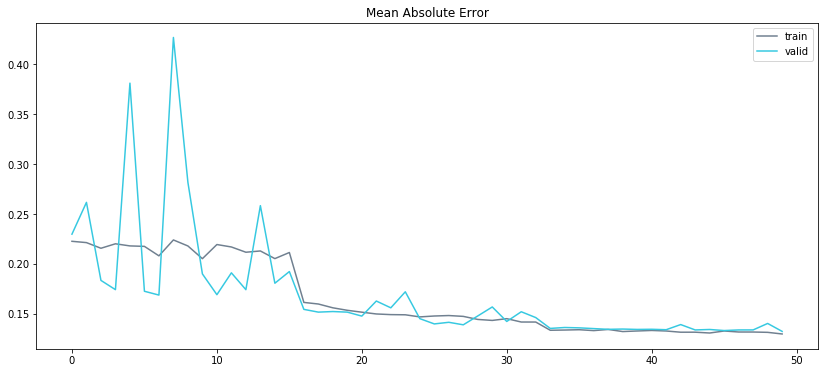

In [22]:
loss_plot(mlp_history2,50)
mae_plot(mlp_history2,50)

In [23]:
mlp_model2.load_weights('mlp_model2.passnyc.hdf5')
y_train_mlp2 = mlp_model2.predict(X_train2)
y_valid_mlp2 = mlp_model2.predict(X_valid2)
y_test_mlp2 = mlp_model2.predict(X_test2)

scores('MLP; \nNumeric Features; \nAverage ELA Proficiency', 
       y_train2, y_valid2, y_test2, y_train_mlp2, y_valid_mlp2, y_test_mlp2)

_______________________________________
MLP; Average ELA Proficiency
_______________________________________
EV score. Train:  0.75543716229998
EV score. Valid:  0.7560081625453668
EV score. Test:  0.7907438072950528
---------
R2 score. Train:  0.7554345977861721
R2 score. Valid:  0.7560065628054187
R2 score. Test:  0.7895391079973189
---------
MSE score. Train:  0.031161381252997885
MSE score. Valid:  0.03354058668881686
MSE score. Test:  0.027381575268034947
---------
MAE score. Train:  0.12969643423709085
MAE score. Valid:  0.13235366059015352
MAE score. Test:  0.1296175038668914
---------
MdAE score. Train:  0.09998045921325693
MdAE score. Valid:  0.10101154327392559
MdAE score. Test:  0.11024654388427724


#### Numeric & encoded categorical features

In [25]:
def mlp_model3():
    model = Sequential()
    
    model.add(Dense(286, input_dim=286))
    model.add(LeakyReLU(alpha=0.02))

    model.add(Dense(286*4))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(Dense(286*16))
    model.add(LeakyReLU(alpha=0.02))
#    model.add(Dense(286*16))
#    model.add(LeakyReLU(alpha=0.02))
    
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model

mlp_model3 = mlp_model3()

In [26]:
mlp_checkpointer3 = ModelCheckpoint(filepath='mlp_model3.passnyc.hdf5', 
                                    verbose=2, save_best_only=True)
mlp_lr_reduction3 = ReduceLROnPlateau(monitor='val_loss', 
                                      patience=5, verbose=2, factor=0.2)

In [27]:
mlp_history3 = mlp_model3.fit(X_train3, y_train3, 
                              epochs=100, batch_size=16, verbose=2,
                              validation_data=(X_valid3, y_valid3),
                              callbacks=[mlp_checkpointer3,mlp_lr_reduction3])

Train on 890 samples, validate on 191 samples
Epoch 1/100
 - 30s - loss: 6885593977.1873 - mean_absolute_error: 17668.4223 - val_loss: 46.1959 - val_mean_absolute_error: 4.5487

Epoch 00001: val_loss improved from inf to 46.19586, saving model to mlp_model3.passnyc.hdf5
Epoch 2/100
 - 23s - loss: 64655.3308 - mean_absolute_error: 131.4389 - val_loss: 6.8512 - val_mean_absolute_error: 1.8647

Epoch 00002: val_loss improved from 46.19586 to 6.85120, saving model to mlp_model3.passnyc.hdf5
Epoch 3/100
 - 24s - loss: 27805.2330 - mean_absolute_error: 74.6229 - val_loss: 2.2485 - val_mean_absolute_error: 1.0708

Epoch 00003: val_loss improved from 6.85120 to 2.24853, saving model to mlp_model3.passnyc.hdf5
Epoch 4/100
 - 22s - loss: 180337987.4246 - mean_absolute_error: 2670.2549 - val_loss: 3.1430 - val_mean_absolute_error: 1.6925

Epoch 00004: val_loss did not improve from 2.24853
Epoch 5/100
 - 21s - loss: 1151.5469 - mean_absolute_error: 10.7679 - val_loss: 129.5558 - val_mean_absolute_


Epoch 00043: val_loss did not improve from 0.22812
Epoch 44/100
 - 25s - loss: 0.5405 - mean_absolute_error: 0.5504 - val_loss: 0.6046 - val_mean_absolute_error: 0.5795

Epoch 00044: val_loss did not improve from 0.22812
Epoch 45/100
 - 26s - loss: 0.5552 - mean_absolute_error: 0.5577 - val_loss: 0.3292 - val_mean_absolute_error: 0.4800

Epoch 00045: val_loss did not improve from 0.22812
Epoch 46/100
 - 26s - loss: 0.5953 - mean_absolute_error: 0.5922 - val_loss: 0.6362 - val_mean_absolute_error: 0.5634

Epoch 00046: val_loss did not improve from 0.22812

Epoch 00046: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
Epoch 47/100
 - 23s - loss: 0.1708 - mean_absolute_error: 0.3111 - val_loss: 0.1166 - val_mean_absolute_error: 0.2524

Epoch 00047: val_loss improved from 0.22812 to 0.11658, saving model to mlp_model3.passnyc.hdf5
Epoch 48/100
 - 25s - loss: 0.1414 - mean_absolute_error: 0.2838 - val_loss: 0.1093 - val_mean_absolute_error: 0.2428

Epoch 00048: val_loss 


Epoch 00086: val_loss did not improve from 0.06729
Epoch 87/100
 - 21s - loss: 0.0716 - mean_absolute_error: 0.2072 - val_loss: 0.0686 - val_mean_absolute_error: 0.2045

Epoch 00087: val_loss did not improve from 0.06729
Epoch 88/100
 - 21s - loss: 0.0733 - mean_absolute_error: 0.2083 - val_loss: 0.0665 - val_mean_absolute_error: 0.1977

Epoch 00088: val_loss improved from 0.06729 to 0.06646, saving model to mlp_model3.passnyc.hdf5
Epoch 89/100
 - 22s - loss: 0.0717 - mean_absolute_error: 0.2064 - val_loss: 0.0714 - val_mean_absolute_error: 0.1976

Epoch 00089: val_loss did not improve from 0.06646
Epoch 90/100
 - 21s - loss: 0.0718 - mean_absolute_error: 0.2060 - val_loss: 0.0693 - val_mean_absolute_error: 0.2055

Epoch 00090: val_loss did not improve from 0.06646
Epoch 91/100
 - 21s - loss: 0.0722 - mean_absolute_error: 0.2077 - val_loss: 0.0690 - val_mean_absolute_error: 0.2042

Epoch 00091: val_loss did not improve from 0.06646
Epoch 92/100
 - 21s - loss: 0.0705 - mean_absolute_er

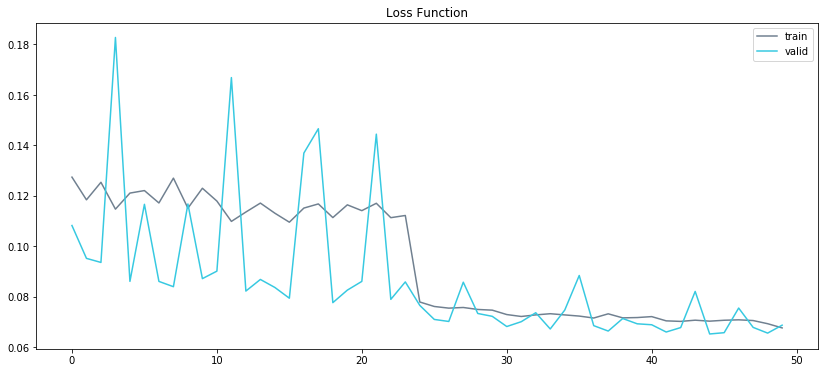

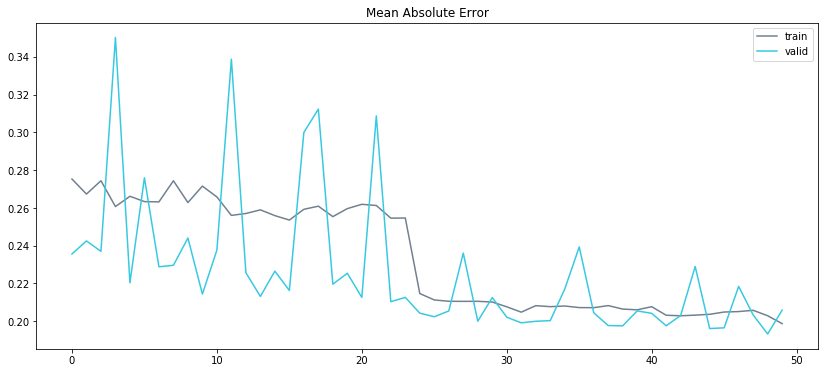

In [29]:
loss_plot(mlp_history3,50)
mae_plot(mlp_history3,50)

In [30]:
mlp_model3.load_weights('mlp_model3.passnyc.hdf5')
y_train_mlp3 = mlp_model3.predict(X_train3)
y_valid_mlp3 = mlp_model3.predict(X_valid3)
y_test_mlp3 = mlp_model3.predict(X_test3)

scores('MLP; \nNumeric & Encoded Categorical Features; \nAverage Math Proficiency', 
       y_train3, y_valid3, y_test3, y_train_mlp3, y_valid_mlp3, y_test_mlp3)

_______________________________________
MLP; 
Numeric & Encoded Categorical Features; 
Average Math Proficiency
_______________________________________
EV score. Train:  0.6984420971019656
EV score. Valid:  0.6908934634666662
EV score. Test:  0.7155998968771822
---------
R2 score. Train:  0.6984372140203696
R2 score. Valid:  0.6904344386149381
R2 score. Test:  0.7136057953078088
---------
MSE score. Train:  0.0664389245661996
MSE score. Valid:  0.06530266603812437
MSE score. Test:  0.059539030621529695
---------
MAE score. Train:  0.19802204847157226
MAE score. Valid:  0.19612684203276043
MAE score. Test:  0.1977268307870595
---------
MdAE score. Train:  0.15509232521057137
MdAE score. Valid:  0.17019481658935565
MdAE score. Test:  0.16738143920898452


In [31]:
def mlp_model4():
    model = Sequential()
    
    model.add(Dense(286, input_dim=286))
    model.add(LeakyReLU(alpha=0.02))

    model.add(Dense(286*4))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(Dense(286*16))
    model.add(LeakyReLU(alpha=0.02))
#    model.add(Dense(286*16))
#    model.add(LeakyReLU(alpha=0.02))
    
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model

mlp_model4 = mlp_model4()

In [32]:
mlp_checkpointer4 = ModelCheckpoint(filepath='mlp_model4.passnyc.hdf5', 
                                    verbose=2, save_best_only=True)
mlp_lr_reduction4 = ReduceLROnPlateau(monitor='val_loss', 
                                      patience=5, verbose=2, factor=0.2)

In [33]:
mlp_history4 = mlp_model4.fit(X_train4, y_train4, 
                              epochs=100, batch_size=16, verbose=2,
                              validation_data=(X_valid4, y_valid4),
                              callbacks=[mlp_checkpointer4,mlp_lr_reduction4])

Train on 890 samples, validate on 191 samples
Epoch 1/100
 - 6s - loss: 204580862.0312 - mean_absolute_error: 2555.5846 - val_loss: 30789.2761 - val_mean_absolute_error: 157.9815

Epoch 00001: val_loss improved from inf to 30789.27606, saving model to mlp_model4.passnyc.hdf5
Epoch 2/100
 - 5s - loss: 76835.1300 - mean_absolute_error: 178.2118 - val_loss: 101929.9735 - val_mean_absolute_error: 288.1636

Epoch 00002: val_loss did not improve from 30789.27606
Epoch 3/100
 - 5s - loss: 6918969.4142 - mean_absolute_error: 567.3356 - val_loss: 500.7723 - val_mean_absolute_error: 20.5663

Epoch 00003: val_loss improved from 30789.27606 to 500.77231, saving model to mlp_model4.passnyc.hdf5
Epoch 4/100
 - 5s - loss: 62781.4263 - mean_absolute_error: 131.2183 - val_loss: 9173.7669 - val_mean_absolute_error: 87.0323

Epoch 00004: val_loss did not improve from 500.77231
Epoch 5/100
 - 6s - loss: 13079.2757 - mean_absolute_error: 42.1439 - val_loss: 42.4877 - val_mean_absolute_error: 5.4163

Epoch 

Epoch 44/100
 - 5s - loss: 0.1045 - mean_absolute_error: 0.2476 - val_loss: 0.0950 - val_mean_absolute_error: 0.2402

Epoch 00044: val_loss did not improve from 0.07193
Epoch 45/100
 - 5s - loss: 0.0999 - mean_absolute_error: 0.2318 - val_loss: 0.0799 - val_mean_absolute_error: 0.2187

Epoch 00045: val_loss did not improve from 0.07193
Epoch 46/100
 - 5s - loss: 0.1023 - mean_absolute_error: 0.2415 - val_loss: 0.0834 - val_mean_absolute_error: 0.2139

Epoch 00046: val_loss did not improve from 0.07193
Epoch 47/100
 - 5s - loss: 0.0874 - mean_absolute_error: 0.2239 - val_loss: 0.1103 - val_mean_absolute_error: 0.2665

Epoch 00047: val_loss did not improve from 0.07193
Epoch 48/100
 - 5s - loss: 0.1031 - mean_absolute_error: 0.2391 - val_loss: 0.0650 - val_mean_absolute_error: 0.1878

Epoch 00048: val_loss improved from 0.07193 to 0.06498, saving model to mlp_model4.passnyc.hdf5
Epoch 49/100
 - 5s - loss: 0.0974 - mean_absolute_error: 0.2353 - val_loss: 0.0707 - val_mean_absolute_error: 

Epoch 88/100
 - 5s - loss: 0.0206 - mean_absolute_error: 0.1044 - val_loss: 0.0260 - val_mean_absolute_error: 0.1143

Epoch 00088: val_loss did not improve from 0.02519
Epoch 89/100
 - 5s - loss: 0.0205 - mean_absolute_error: 0.1057 - val_loss: 0.0249 - val_mean_absolute_error: 0.1130

Epoch 00089: val_loss improved from 0.02519 to 0.02489, saving model to mlp_model4.passnyc.hdf5
Epoch 90/100
 - 5s - loss: 0.0202 - mean_absolute_error: 0.1063 - val_loss: 0.0254 - val_mean_absolute_error: 0.1131

Epoch 00090: val_loss did not improve from 0.02489
Epoch 91/100
 - 5s - loss: 0.0198 - mean_absolute_error: 0.1041 - val_loss: 0.0355 - val_mean_absolute_error: 0.1389

Epoch 00091: val_loss did not improve from 0.02489
Epoch 92/100
 - 5s - loss: 0.0202 - mean_absolute_error: 0.1039 - val_loss: 0.0248 - val_mean_absolute_error: 0.1129

Epoch 00092: val_loss improved from 0.02489 to 0.02484, saving model to mlp_model4.passnyc.hdf5
Epoch 93/100
 - 5s - loss: 0.0200 - mean_absolute_error: 0.1038 -

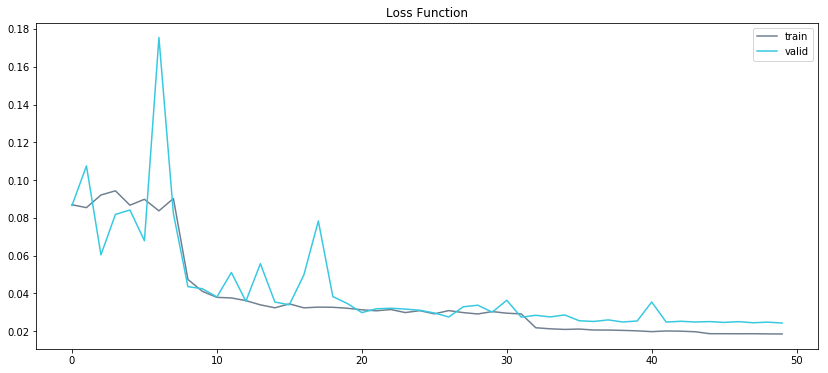

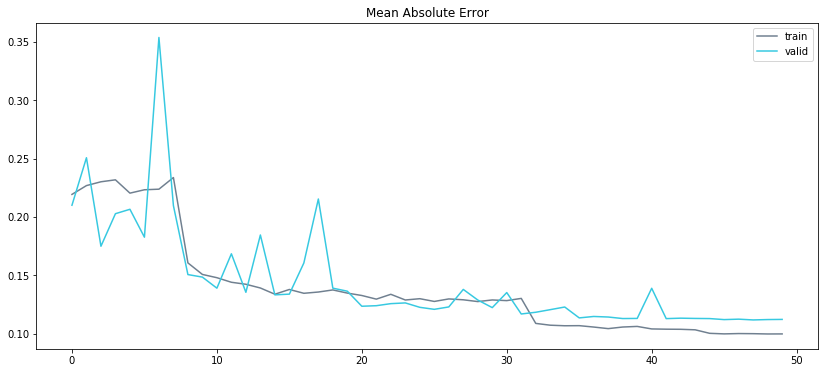

In [34]:
loss_plot(mlp_history4,50)
mae_plot(mlp_history4,50)

In [35]:
mlp_model4.load_weights('mlp_model4.passnyc.hdf5')
y_train_mlp4 = mlp_model4.predict(X_train4)
y_valid_mlp4 = mlp_model4.predict(X_valid4)
y_test_mlp4 = mlp_model4.predict(X_test4)

scores('MLP; \nNumeric & Encoded Categorical Features; \nAverage ELA Proficiency', 
       y_train4, y_valid4, y_test4, y_train_mlp4, y_valid_mlp4, y_test_mlp4)

_______________________________________
MLP; 
Numeric & Encoded Categorical Features; 
Average ELA Proficiency
_______________________________________
EV score. Train:  0.8564785163977531
EV score. Valid:  0.8237312177884764
EV score. Test:  0.8012572448189919
---------
R2 score. Train:  0.854279712138929
R2 score. Valid:  0.8228472939809596
R2 score. Test:  0.7997450340152694
---------
MSE score. Train:  0.018566998460253562
MSE score. Valid:  0.02435231767587095
MSE score. Test:  0.02605375455616157
---------
MAE score. Train:  0.09884878887933736
MAE score. Valid:  0.11225766181113622
MAE score. Test:  0.12198023060437477
---------
MdAE score. Train:  0.07309062004089362
MdAE score. Valid:  0.09524939537048338
MdAE score. Test:  0.09687203407287592


In this case, neural networks were used to predict the indicators of educational outcomes. 

It is difficult to achieve high accuracy here in general since the ultimate goal depends not only on the financing, social environment and professionalism of the staff but also on the personal qualities of the students. Adding category variables does not improve the accuracy of predictions too strongly because these indicators depend not exactly on geolocations but on the well-being of the surrounding area.

I believe that it is possible to reach at least the same accuracy with neural networks as with regression algorithms like Gradient Boosting or Random Forest.